<a href="https://colab.research.google.com/github/Lavan1999/Dataset-9-Examdataset/blob/main/Student_Exam_Performance_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Librarys**

In [ ]:
import pandas as pd
import numpy as np

#Connections
from google.colab import drive

#Statistic
from scipy import stats

#Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
import statsmodels.api as sm

# **Connections**

In [ ]:
#Google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DataFrame**

In [ ]:
#Google drive
file_path = '/content/drive/My Drive/MDTM15/Raw Datasets/student_exam_data.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1
2,7.587945,58.571657,0
3,6.387926,88.827701,1
4,2.404168,81.083870,0


# **DataFrame observation**


In [ ]:
# Dependent - Pass/Fail
# Independent - Study Hours,	Previous Exam Score

continuous_columns = ["Study Hours", "Previous Exam Score"]
category_columns = ["Pass/Fail"]

#Supervised binery classification

# **Data cleaning using pandas**


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Study Hours          500 non-null    float64
 1   Previous Exam Score  500 non-null    float64
 2   Pass/Fail            500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [ ]:
df.isnull().sum()

Study Hours            0
Previous Exam Score    0
Pass/Fail              0
dtype: int64

# **Hypothesis testing / Statistical analysis**


Continuous - Central Limit Theorem, 1-Tailed Test (one-sample t-test)

Continuous vs. Continuous - Correlation, 2-Tailed Test (two-sample t-test)

Continuous vs. Categorical - ANOVA (Analysis of Variance)

Categorical vs. Categorical - Chi-Square Test

In [ ]:
def hypothesisTesting(continuous_columns = [], category_columns = [], sampling_rate = 0.20, sampling_frac=0.05):
  #Central Limit Theorem
  oneContinesColumn_result = {}
  hypothesis_df = pd.DataFrame(columns=df.columns, index=df.columns)
  if continuous_columns:
    samplesize = int(sampling_rate * len(df[continuous_columns[0]]))
    for column in continuous_columns:
      population=df[column].values
      population_mean = population.mean()
      sample_mean=[]
      for i in range(40):
        sample=np.random.choice(population,samplesize)
        sample_mean.append(sample.mean())
      oneContinesColumn_result[column] = {
                                          "Population Mean": population_mean,
                                          "Sample Means": {np.mean(sample_mean)}
                                          }

  #1-Tailed Test
  if continuous_columns:
    samplesize = int(sampling_rate * len(df[continuous_columns[0]]))
    for column in continuous_columns:
      H0_accepted = 0
      H0_rejected = 0
      for i in range(samplesize):
        sample=df[column].sample(frac=sampling_frac)
        t_test,p_value=stats.ttest_1samp(sample,df[column].mean())
        if p_value > 0.5:
          H0_accepted += 1
        else:
          H0_rejected += 1

      if H0_accepted > H0_rejected:
          oneContinesColumn_result[column].update( {
                                            "H0_accepted": H0_accepted,
                                            "H0_rejected": H0_rejected,
                                            "Conclusion": "H0 is accepted, Ha is rejected, There is no significant effect"
                                          } )
          hypothesis_df[column][column] = "There is a relationship"

      else:
          oneContinesColumn_result[column].update( {
                                              "H0_accepted": H0_accepted,
                                              "H0_rejected": H0_rejected,
                                              "Conclusion": "H0 is rejected, Ha is accepted, There is a significant effect"
                                              } )
          hypothesis_df[column][column] = "There is no relationship"


  #2-Tailed Test
  for i in range(len(continuous_columns) - 1):
      column_1 = continuous_columns[i]
      for column_2 in continuous_columns[i+1:]:
        H0_accepted = 0
        H0_rejected = 0
        for i in range(20):
          sample1 = df[column_1].sample(frac=sampling_frac)
          sample2 = df[column_2].sample(frac=sampling_frac)
          t_test, p_value = stats.ttest_ind(sample1, sample2)
          if p_value > 0.5:
            H0_accepted += 1
          else:
            H0_rejected += 1

        if H0_accepted > H0_rejected:
          #H0 is accepted, Ha is rejected, There is no significant effect. "H0_accepted": H0_accepted, "H0_rejected": H0_rejected
          hypothesis_df[column_1][column_2] = "There is a relationship"
          hypothesis_df[column_2][column_1] = "There is a relationship"
        else:
          #H0 is rejected, Ha is accepted, There is a significant effect. "H0_accepted": H0_accepted, "H0_rejected": H0_rejected
            hypothesis_df[column_1][column_2] = "There is no relationship"
            hypothesis_df[column_2][column_1] = "There is no relationship"

  #Chi-Square Test
  if category_columns:
    for i in range(len(category_columns) - 1):
        column_1 = category_columns[i]
        for column_2 in category_columns[i + 1:]:
            data = pd.crosstab(df[column_1], df[column_2])
            observed_values = data.values
            chi2_stat, p_value, _, _ = stats.chi2_contingency(observed_values)

            if p_value > 0.05:
                # H0 is accepted, There is no relationship between two columns we're comparing
                hypothesis_df[column_1][column_2] = "There is no relationship"
                hypothesis_df[column_2][column_1] = "There is no relationship"
            else:
                # H0 is rejected, There is a relationship between two columns we're comparing
                hypothesis_df[column_1][column_2] = "There is a relationship"
                hypothesis_df[column_2][column_1] = "There is a relationship"

  #ANOVA
  if continuous_columns and category_columns:
    for category_column in category_columns:
      for continuous_column in continuous_columns:
        group = df[category_column].unique()
        data = {}
        for i in group:
          data[i]=df[continuous_column][df[category_column]==i]

        f_value, p_value = stats.f_oneway(*[data[i] for i in group])
        if p_value > 0.05:
            # H0 is accepted, There is a relationship between two columns we're comparing
            hypothesis_df[category_column][continuous_column] = "There is a relationship"
            hypothesis_df[continuous_column][category_column] = "There is a relationship"
        else:
            # H0 is rejected, There is no relationship between two columns we're comparing
            hypothesis_df[category_column][continuous_column] = "There is no relationship"
            hypothesis_df[continuous_column][category_column] = "There is no relationship"

  return oneContinesColumn_result, hypothesis_df

# Correlation

In [ ]:
df.corr()

,Study Hours,Previous Exam Score,Pass/Fail
Study Hours,1.000000,0.010354,0.583505
Previous Exam Score,0.010354,1.000000,0.443706
Pass/Fail,0.583505,0.443706,1.000000


# **Result Hypothesis**

In [ ]:
ContinesColumn_result, comperativeColumn_result = hypothesisTesting(continuous_columns , category_columns)

In [ ]:
ContinesColumn_result_df = pd.DataFrame(ContinesColumn_result)
ContinesColumn_result_df

,Study Hours,Previous Exam Score
Population Mean,5.487055,68.917084
Sample Means,{5.478682833277114},{69.08103767051495}
H0_accepted,51,46
H0_rejected,49,54
Conclusion,"H0 is accepted, Ha is rejected, There is no si...","H0 is rejected, Ha is accepted, There is a sig..."


In [ ]:
comperativeColumn_result

,Study Hours,Previous Exam Score,Pass/Fail
Study Hours,There is a relationship,There is no relationship,There is no relationship
Previous Exam Score,There is no relationship,There is no relationship,There is no relationship
Pass/Fail,There is no relationship,There is no relationship,NaN


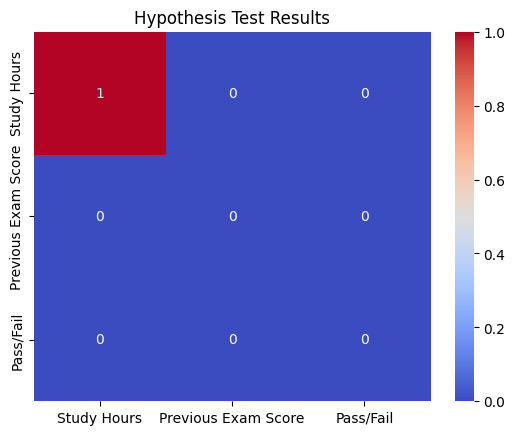

In [ ]:
# Create a heatmap
sns.heatmap(comperativeColumn_result == 'There is a relationship', annot=True, cmap='coolwarm')
plt.title('Hypothesis Test Results')
plt.show()

# **Data Visualization**

In [ ]:
fig = px.scatter(df, x = "Previous Exam Score", y = "Pass/Fail")
fig.show()

# **Machine Learning**

In [ ]:
# 1 data availability
# 2 separating independent and dependent
# 3 identifying algorithms/Model
# 4 training
# 5 evaluation

In [ ]:
df.head()

,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1
2,7.587945,58.571657,0
3,6.387926,88.827701,1
4,2.404168,81.083870,0


In [ ]:
y = df["Pass/Fail"]
x1 = df[["Study Hours",	"Previous Exam Score"]]
x = sm.add_constant(x1)
result = sm.Logit(y, x).fit()
result.pred_table()

Optimization terminated successfully.
         Current function value: 0.269134
         Iterations 8


array([[284.,  32.],
       [ 34., 150.]])

In [ ]:
cm_df=pd.DataFrame(result.pred_table())
cm=np.array(cm_df)
acc=(cm[0,0]+cm[1,1])/cm.sum()
print(acc*100)

86.8


In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Pass/Fail   No. Observations:                  500
Model:                          Logit   Df Residuals:                      497
Method:                           MLE   Df Model:                            2
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  0.5909
Time:                        10:06:00   Log-Likelihood:                -134.57
converged:                       True   LL-Null:                       -328.94
Covariance Type:            nonrobust   LLR p-value:                 3.840e-85
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -17.7586      1.723    -10.305      0.000     -21.136     -14.381
Study Hours             1.1457      0.114     10.061      0.000       0.923       1.369
Previous Exam Score     0.1431      0.015      9.412      0.000       0.113       0.173
=======================================================================================
"""

In [ ]:
cm_df=pd.DataFrame(result.pred_table())
cm_df.columns=["predicted 0","predicted 1"]
cm_df=cm_df.rename(index={0:"actual 0",1:"actual 1"})
cm_df

,predicted 0,predicted 1
actual 0,284.0,32.0
actual 1,34.0,150.0
